In [3]:
# =========================
# 03_user_clustering.ipynb
# =========================

"""
User Clustering Analysis Notebook
- Clustering results: Behavior, Preference, Lifecycle
- Merge user features + cluster assignments
- Visualizations: bar chart, PCA 2D scatter, cross-tab heatmap
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

sns.set(style="whitegrid")


In [4]:
# Behavior
behavior_assign = pd.read_csv("../results/behavior/behavior_cluster_assignments.csv")
behavior_features = pd.read_csv("../dataset/processed/behavior_features.csv")

# Merge
behavior_data = behavior_assign.merge(behavior_features, on="user_id")

# Preference
preference_assign = pd.read_csv("../results/preference/preference_cluster_assignments.csv")
preference_features = pd.read_csv("../dataset/processed/preference_features.csv")

preference_data = preference_assign.merge(preference_features, on="user_id")

# Lifecycle
lifecycle_assign = pd.read_csv("../results/lifecycle/lifecycle_assignments.csv")
lifecycle_features = pd.read_csv("../dataset/processed/lifecycle_features.csv")

lifecycle_data = lifecycle_assign.merge(lifecycle_features, on="user_id")

In [5]:
behavior_summary = pd.read_csv("../results/behavior/behavior_cluster_summary.csv")
preference_summary = pd.read_csv("../results/preference/preference_cluster_summary.csv")
lifecycle_summary = pd.read_csv("../results/lifecycle/lifecycle_summary.csv")

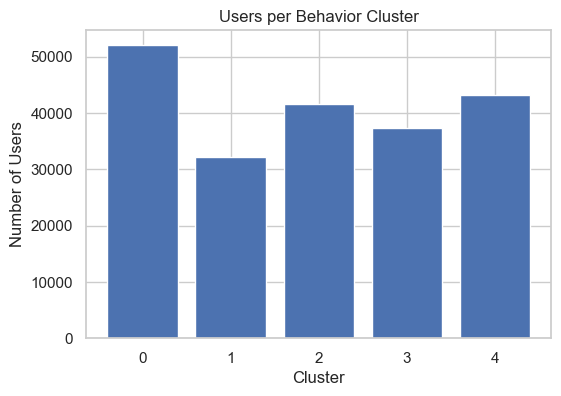

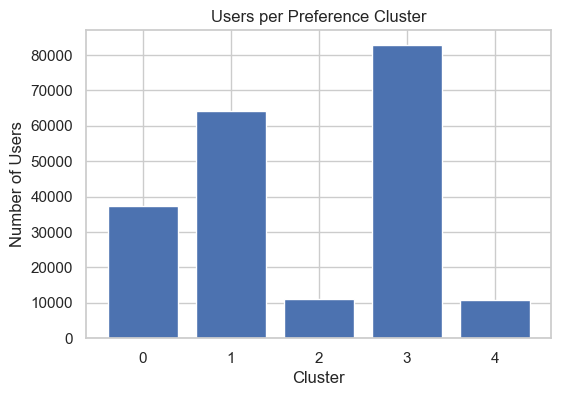

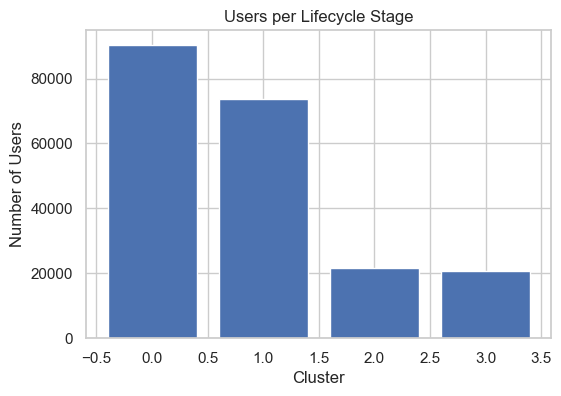

In [6]:
def plot_users_bar(summary, cluster_col="cluster", user_col="num_users", title="Users per Cluster"):
    plt.figure(figsize=(6,4))
    plt.bar(summary.index, summary[user_col])
    plt.xlabel("Cluster")
    plt.ylabel("Number of Users")
    plt.title(title)
    plt.show()

plot_users_bar(behavior_summary, user_col='num_users', title="Users per Behavior Cluster")
plot_users_bar(preference_summary, user_col='num_users', title="Users per Preference Cluster")
plot_users_bar(lifecycle_summary, user_col='num_users', title="Users per Lifecycle Stage")


In [7]:
# Behavior
print("Behavior Cluster Description:")
if 'Đặc trưng chính' in behavior_summary.columns:
    feat_col, desc_col = 'Đặc trưng chính', 'Mô tả'
else:
    feat_col, desc_col = None, None

for idx, row in behavior_summary.iterrows():
    if feat_col and desc_col:
        print(f"Cluster {idx}: {row[feat_col]} – {row[desc_col]} ({row['num_users']} users)")
    else:
        print(f"Cluster {idx}: {row['num_users']} users")

# Preference
print("\nPreference Cluster Description:")
if 'Top preference categories' in preference_summary.columns:
    feat_col = 'Top preference categories'
else:
    feat_col = None

for idx, row in preference_summary.iterrows():
    if feat_col:
        print(f"Cluster {int(row['cluster'])}: {row[feat_col]} ({row['num_users']} users)")
    else:
        print(f"Cluster {int(row['cluster'])}: {row['num_users']} users")

# Lifecycle
print("\nLifecycle Stage Description:")
for idx, row in lifecycle_summary.iterrows():
    print(f"Stage {int(row['cluster']) if 'cluster' in row else idx}: {row['num_users']} users")


Behavior Cluster Description:
Cluster 0: Hoạt động ổn định – Nhóm người dùng chủ lực (52065 users)
Cluster 1: Nhiều đơn, mua đều – Người dùng trung thành (32158 users)
Cluster 2: Ít đơn, ít mua – Người dùng không thường xuyên (41536 users)
Cluster 3: Ít đơn, ít mua – Người dùng không thường xuyên (37305 users)
Cluster 4: Mức trung bình – Người dùng phổ thông (43145 users)

Preference Cluster Description:
Cluster 0: produce, dairy eggs, pantry (37249 users)
Cluster 1: dairy eggs, produce, frozen (64229 users)
Cluster 2: beverages, produce, snacks (10984 users)
Cluster 3: produce, dairy eggs, snacks (82815 users)
Cluster 4: snacks, beverages, produce (10932 users)

Lifecycle Stage Description:
Stage 0: 90345 users
Stage 1: 73591 users
Stage 2: 21629 users
Stage 3: 20644 users


<Figure size 1000x500 with 0 Axes>

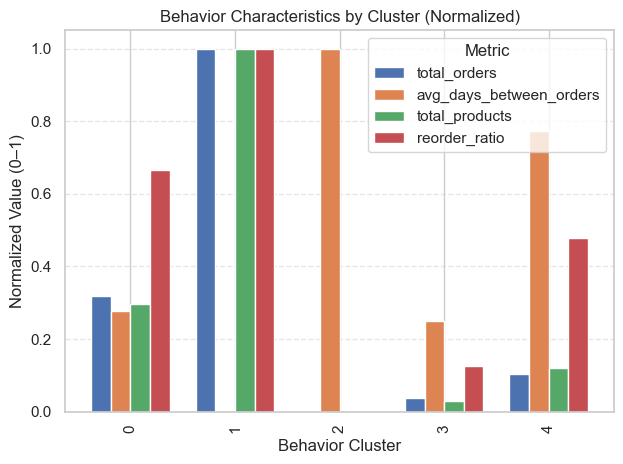

In [8]:
metrics = [
    "total_orders",
    "avg_days_between_orders",
    "total_products",
    "reorder_ratio"
]

# -------------------------------
# NORMALIZE (0–1)
# -------------------------------
scaler = MinMaxScaler()
df_scaled = behavior_summary.copy()
df_scaled[metrics] = scaler.fit_transform(behavior_summary[metrics])

df_scaled = df_scaled.set_index("cluster")

# -------------------------------
# GROUPED BAR CHART
# -------------------------------
plt.figure(figsize=(10,5))

df_scaled[metrics].plot(
    kind="bar",
    width=0.75
)

plt.title("Behavior Characteristics by Cluster (Normalized)")
plt.xlabel("Behavior Cluster")
plt.ylabel("Normalized Value (0–1)")
plt.legend(title="Metric")
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

In [9]:
def plot_cluster_pca(
    df, feature_cols, cluster_col, title
):
    X = df[feature_cols]
    y = df[cluster_col]

    # Scale (giống lúc train KMeans)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # PCA for visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    var_ratio = pca.explained_variance_ratio_

    # PCA dataframe
    pca_df = pd.DataFrame(
        X_pca, columns=["PC1", "PC2"]
    )
    pca_df["cluster"] = y.values

    # Plot points
    plt.figure(figsize=(7,5))
    sns.scatterplot(
        data=pca_df,
        x="PC1",
        y="PC2",
        hue="cluster",
        palette="tab10",
        alpha=0.6,
        s=50
    )

    # Centroid in PCA space
    centroids = (
        pca_df
        .groupby("cluster")[["PC1", "PC2"]]
        .mean()
    )

    plt.scatter(
        centroids["PC1"],
        centroids["PC2"],
        marker="X",
        s=100,
        c="black",
        linewidths=1.5,
        label="Centroid (PCA)"
    )
    
    print(f"PC1 ({var_ratio[0]*100:.1f}%)")
    print(f"PC2 ({var_ratio[1]*100:.1f}%)")

    plt.xlabel(f"PC1 ({var_ratio[0]*100:.1f}%)")
    plt.ylabel(f"PC2 ({var_ratio[1]*100:.1f}%)")
    plt.title(title)
    plt.tight_layout()
    plt.show()

PC1 (69.3%)
PC2 (14.3%)


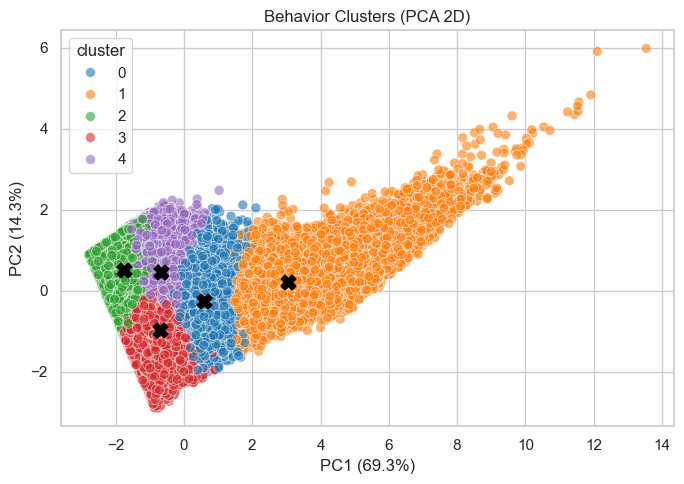

In [10]:
behavior_feature_cols = [c for c in behavior_features.columns if c != "user_id"]
plot_cluster_pca(
    behavior_data,
    behavior_feature_cols,
    cluster_col="cluster",
    title="Behavior Clusters (PCA 2D)"
)


<Figure size 1200x500 with 0 Axes>

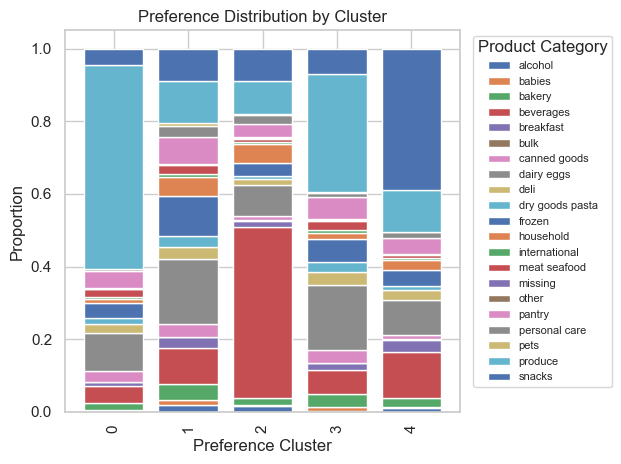

In [11]:
category_cols = [
    c for c in preference_summary.columns
    if c not in ["cluster", "num_users", "Top preference categories"]
]

# Set cluster làm index
plot_df = preference_summary.set_index("cluster")[category_cols]

# -------------------------------
# STACKED BAR CHART
# -------------------------------
plt.figure(figsize=(12,5))

plot_df.plot(
    kind="bar",
    stacked=True,
    width=0.8
)

plt.title("Preference Distribution by Cluster")
plt.xlabel("Preference Cluster")
plt.ylabel("Proportion")
plt.legend(
    title="Product Category",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    fontsize=8
)

plt.tight_layout()
plt.show()


PC1 (9.3%)
PC2 (7.1%)


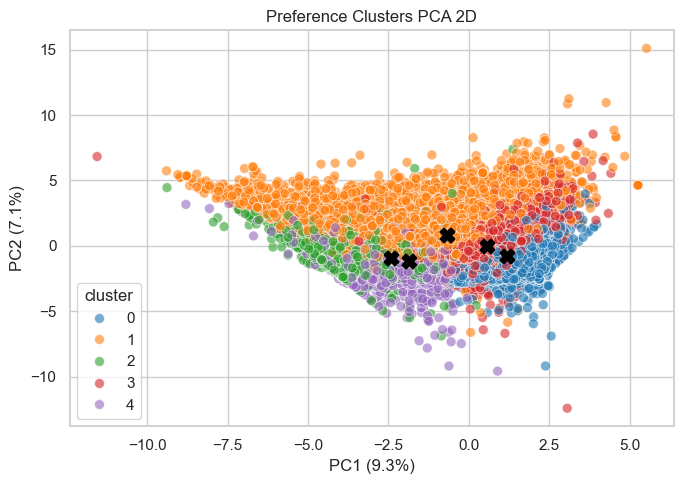

In [12]:

preference_wide = (
    preference_features
    .pivot_table(
        index="user_id",
        columns="department",
        values="preference_score",
        fill_value=0.0
    )
    .reset_index()
)
preference_data = preference_assign.merge(
    preference_wide,
    on="user_id",
    how="inner"
)
preference_feature_cols = (
    preference_wide
    .columns
    .drop("user_id")
    .tolist()
)

plot_cluster_pca(
    preference_data,
    preference_feature_cols,
    cluster_col="cluster",
    title="Preference Clusters PCA 2D"
)


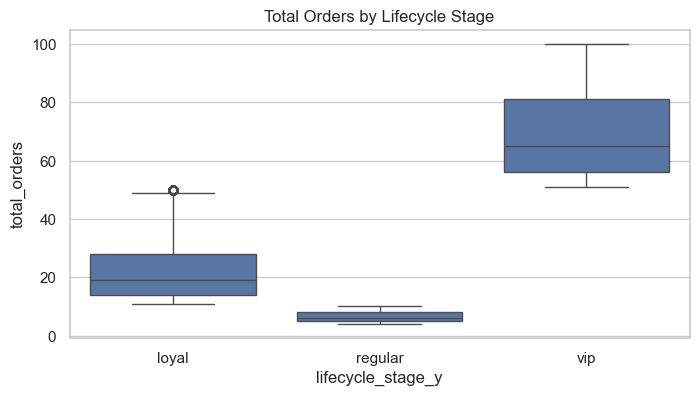

In [14]:
lifecycle_feature_cols = [
    "total_orders",
    "active_days",
    "active_span"
]
plt.figure(figsize=(8,4))
sns.boxplot(
    data=lifecycle_data,
    x="lifecycle_stage_y",
    y="total_orders"
)
plt.title("Total Orders by Lifecycle Stage")
plt.show()



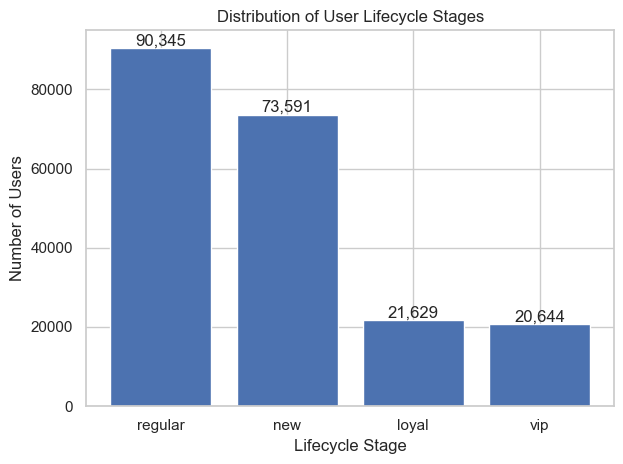

In [16]:
plt.figure()
plt.bar(lifecycle_summary["lifecycle_stage"], lifecycle_summary["num_users"])

plt.xlabel("Lifecycle Stage")
plt.ylabel("Number of Users")
plt.title("Distribution of User Lifecycle Stages")

for i, v in enumerate(lifecycle_summary["num_users"]):
    plt.text(i, v, f"{v:,}", ha="center", va="bottom")

plt.tight_layout()
plt.show()

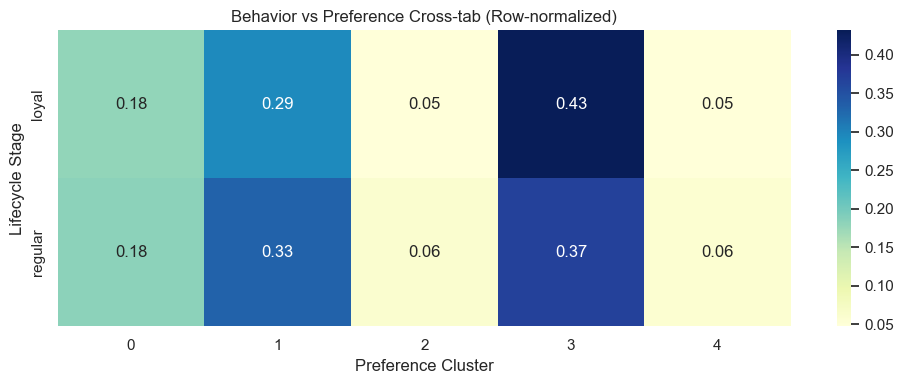

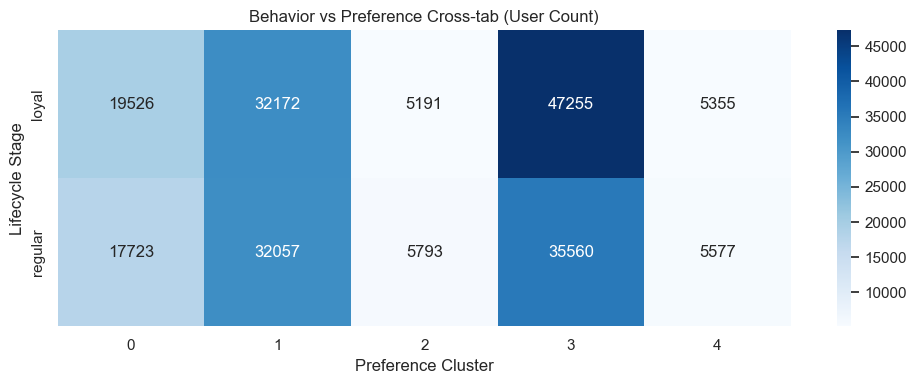

In [ ]:
# 4. HEATMAP – RATIO 

behavior_pref = (
    lifecycle_assign
    .merge(
        preference_assign,
        on="user_id",
        how="inner"
    )
)

crosstab_count = pd.crosstab(
    behavior_pref["lifecycle_stage"],
    behavior_pref["cluster"]
)

crosstab_ratio = crosstab_count.div(
    crosstab_count.sum(axis=1),
    axis=0
)

plt.figure(figsize=(10,4))
sns.heatmap(
    crosstab_ratio,
    annot=True,
    fmt=".2f",
    cmap="YlGnBu"
)

plt.title("Behavior vs Preference Cross-tab (Row-normalized)")
plt.xlabel("Preference Cluster")
plt.ylabel("Lifecycle Stage")
plt.tight_layout()
plt.show()

# 5. HEATMAP – USER COUNT
plt.figure(figsize=(10,4))
sns.heatmap(
    crosstab_count,
    annot=True,
    fmt="d",
    cmap="Blues"
)

plt.title("Behavior vs Preference Cross-tab (User Count)")
plt.xlabel("Preference Cluster")
plt.ylabel("Lifecycle Stage")
plt.tight_layout()
plt.show()